In [8]:
import json
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
from matplotlib import colors as mcolors
import numpy as np
import pandas as pd
import re
from adjustText import adjust_text

# Data source directory
src = "SUMMARIZED_DATA"
xticks = [0,0.5,1,2,5,10]

In [9]:
def adjust_text_safe(texts, ax=None):
	try:
		adjust_text(texts, ax=ax, only_move={'points': 'y', 'texts': 'y'}, arrowprops=dict(arrowstyle='-', color='gray'))
	except Exception:
		pass

def pareto_frontier_indices(xs, ys, maximize_x=True, maximize_y=True):
    """Return indices of points on the Pareto frontier (non-dominated).
    xs, ys: lists or arrays of numbers.
    maximize_x/y: whether larger values are better for that axis.
    Returns: list of indices (sorted by x ascending).
    """
    if not xs or not ys or len(xs) != len(ys):
        return []
    pts = list(enumerate(zip(xs, ys)))
    pts.sort(key=lambda iv: iv[1][0], reverse=maximize_x)
    frontier = []
    if maximize_y:
        best_y = float('-inf')
        for idx, (x, y) in pts:
            if y >= best_y:
                frontier.append(idx)
                best_y = y
    else:
        best_y = float('inf')
        for idx, (x, y) in pts:
            if y <= best_y:
                frontier.append(idx)
                best_y = y
    return sorted(frontier, key=lambda i: xs[i])

def highlight_pareto(ax, xs, ys, indices, marker='^', color='black', size=80, filled=True):
    """Change existing scatter points at given indices to use a triangle marker.
    This modifies the existing PathCollection for the matching (x,y) offsets
    instead of overlaying new markers.
    """

    try:
        marker_style = MarkerStyle(marker)
        marker_path = marker_style.get_path().transformed(marker_style.get_transform())
    except Exception:
        marker_path = None

    for i in indices:
        x = xs[i]
        y = ys[i]
        # each scatter(...) call creates a PathCollection stored in ax.collections
        for coll in list(ax.collections):
            try:
                offsets = coll.get_offsets()  # Nx2 array
                if offsets is None or len(offsets) == 0:
                    continue
                # check if this collection contains the point (x,y)
                if np.any(np.all(np.isclose(offsets, [x, y], atol=1e-8), axis=1)):
                    # change marker path for this collection (works for single-point scatters)
                    if marker_path is not None:
                        try:
                            coll.set_paths([marker_path])
                        except Exception:
                            pass
                    # set size (scatter sizes are in points**2; passing single-element list keeps it per-collection)
                    try:
                        coll.set_sizes([size])
                    except Exception:
                        pass
                    # set face/edge colors according to filled flag
                    try:
                        if filled:
                            coll.set_facecolors(color)
                            # keep a visible edge for contrast
                            coll.set_edgecolors('k')
                        else:
                            coll.set_facecolors('none')
                            coll.set_edgecolors(color)
                    except Exception:
                        pass
                    # bring to front
                    try:
                        coll.set_zorder(5)
                    except Exception:
                        pass
                    break
            except Exception:
                continue
        
_family_color_map = {}
# Generate visually distinct colors on demand using HSV + golden-ratio spacing
# (no extra dependencies; works for many families)


def _distinct_color(n):
    """Return a hex color for index n using golden-ratio spaced hues."""
    hue = (n * 0.618033988749895) % 1.0  # golden ratio conjugate spacing
    rgb = tuple(mcolors.hsv_to_rgb((hue, 0.65, 0.9)))  # (h, s, v) -> rgb, convert ndarray to tuple
    return mcolors.to_hex(rgb)

def get_family(model_name):
    """Heuristic: family is first token before '_', '-', whitespace, or any digit."""
    toks = re.split(r"[_\-\d\s]+", model_name)
    for t in toks:
        if t:
            return t.lower()
    return model_name.lower()

def get_color_for_family(family):
    """Return a consistent hex color for each family (cached)."""
    if family in _family_color_map:
        return _family_color_map[family]
    color = _distinct_color(len(_family_color_map))
    _family_color_map[family] = color
    return color

def family_legend_handles():
    """Return legend handles + labels for families plotted so far."""
    handles = []
    labels = []
    for fam, col in _family_color_map.items():
        h = Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markeredgecolor='k',
                   markersize=8, linestyle='None')
        handles.append(h)
        labels.append(fam)
    return handles, labels


15 [-0.47472104 -0.45580002]
28 [ 0.92313423 -0.85724226]
15 [-0.42631712 -0.98179213]
28 [ 0.7494053 -0.3905562]
7 [0.40424775 0.87219423]
9 [ 0.87092423 -0.75260996]
16 [0.13909159 0.5652071 ]
17 [-0.68970145 -0.46799839]
7 [ 0.39941508 -0.77504919]
9 [0.51411759 0.25280014]
16 [ 0.24708181 -0.17156221]
17 [-0.24297579  0.10891507]
9 [0.94361712 0.4353056 ]
17 [0.48017837 0.62829419]
7 [0.40424775 0.87219423]
9 [ 0.87092423 -0.75260996]
16 [0.13909159 0.5652071 ]
17 [-0.68970145 -0.46799839]
7 [ 0.39941508 -0.77504919]
9 [0.51411759 0.25280014]
16 [ 0.24708181 -0.17156221]
17 [-0.24297579  0.10891507]
9 [0.94361712 0.4353056 ]
17 [0.48017837 0.62829419]


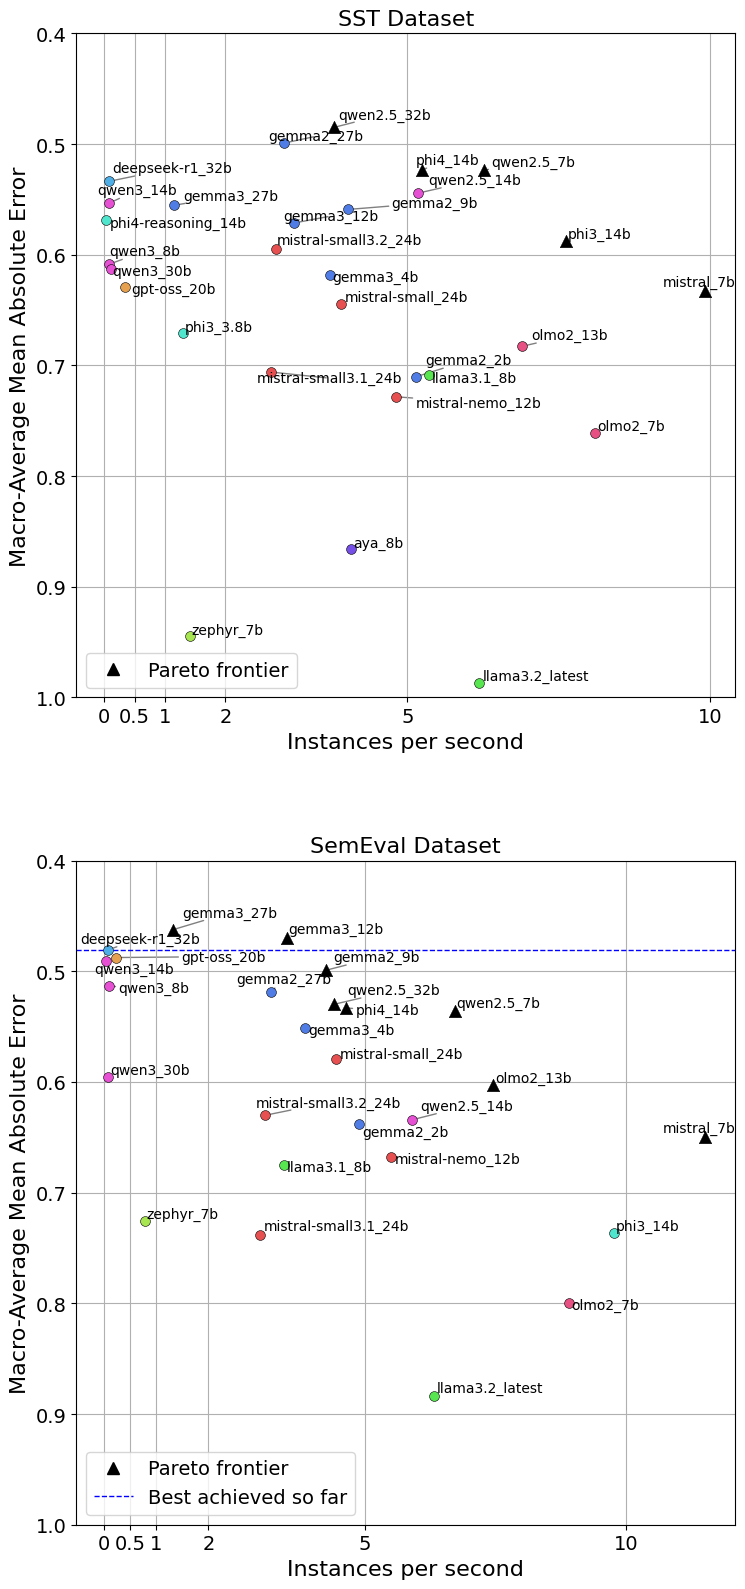

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(8, 16))

axes[0].set_xlabel("Instances per second\n\n\n‎ ", fontsize=16)
axes[0].set_ylabel("Macro-Average Mean Absolute Error", fontsize=16)
axes[0].set_title("SST Dataset", fontsize=16)
# axes[0].set_xscale('log')
axes[0].tick_params(axis='y', labelsize=14)

axes[1].set_xlabel("Instances per second", fontsize=16)
axes[1].set_ylabel("Macro-Average Mean Absolute Error", fontsize=16)
axes[1].set_title("SemEval Dataset", fontsize=16)
# axes[1].set_xscale('log')
axes[1].tick_params(axis='y', labelsize=14)

axes[0].set_xticks(xticks)
axes[0].set_xticklabels([str(t) for t in xticks], fontsize=14)

axes[1].set_xticks(xticks)
axes[1].set_xticklabels([str(t) for t in xticks], fontsize=14)

# Ensure every plot starts at y=0
# axes[0].set_ylim(bottom=0.4, top=1)
# axes[1].set_ylim(bottom=0.4, top=1)

axes[0].set_ylim(bottom=0.4, top=1)
axes[1].set_ylim(bottom=0.4, top=1)

# Invert MAE y-axis direction (reversed orientation)
axes[0].invert_yaxis()
axes[1].invert_yaxis()

texts_sst = []
texts_semeval = []
xs_sst = []
ys_sst = []
xs_semeval = []
ys_semeval = []

for file in os.listdir(src):
    if file[-4:] != 'json':
        continue
    #if file[:3] == "phi" or file[:3] == "zep" or file[:3] == "aya":
        #continue
    path = os.path.join(src, file)
    with open(path, "r") as f:
        performance = json.load(f)
        model_name = file[:-9] if file[-8:] == "sst.json" else file[:-13]
        if file[-8:] == "sst.json":
            x = 1000 / performance["Average end-to-end latency"]
            y = performance["Macro-Average Mean Absolute Error"]
            family = get_family(model_name)
            color = get_color_for_family(family)
            axes[0].scatter(x, y, color=color, s=50, edgecolors='k', linewidths=0.4, zorder=3)
            t = axes[0].annotate(model_name, (x, y))
            texts_sst.append(t)
            xs_sst.append(x)
            ys_sst.append(y)
        else:  # semeval
            x = 1000 / performance["Average end-to-end latency"]
            y = performance["Macro-Average Mean Absolute Error"]
            family = get_family(model_name)
            color = get_color_for_family(family)
            axes[1].scatter(x, y, color=color, s=50, edgecolors='k', linewidths=0.4, zorder=3)
            t = axes[1].annotate(model_name, (x, y))
            texts_semeval.append(t)
            xs_semeval.append(x)
            ys_semeval.append(y)

plt.tight_layout()
for ax in axes:
    ax.grid(True)
adjust_text_safe(texts_sst, ax=axes[0])
adjust_text_safe(texts_semeval, ax=axes[1])
# Pareto highlighting: lower is better for MSE
s_idx = pareto_frontier_indices(xs_sst, ys_sst, maximize_x=True, maximize_y=False)
se_idx = pareto_frontier_indices(xs_semeval, ys_semeval, maximize_x=True, maximize_y=False)
highlight_pareto(axes[0], xs_sst, ys_sst, s_idx)
highlight_pareto(axes[1], xs_semeval, ys_semeval, se_idx)
# SemEval reference line at y=0.481
axes[1].axhline(0.481, color='blue', linestyle='--', linewidth=1)

# Legend: explain Pareto squares and best-achieved (dashed blue)
pareto_handle = Line2D([0], [0], marker='^', color='black', linestyle='None', markersize=8)
best_handle = Line2D([0], [0], color='blue', linestyle='--', linewidth=1)
axes[0].legend([pareto_handle], ['Pareto frontier'], loc='lower left', fontsize=14)
axes[1].legend([pareto_handle, best_handle], ['Pareto frontier', 'Best achieved so far'], loc='lower left', fontsize=14)

plt.show()

7 [ 0.77933404 -0.89666791]
9 [ 0.85218986 -0.30926438]
13 [-0.07849606  0.57015727]
16 [-0.58435469  0.89526341]
7 [0.82059185 0.26972898]
9 [0.96076042 0.28023081]
13 [-0.49680946 -0.04776307]
16 [-0.78007805  0.99939938]


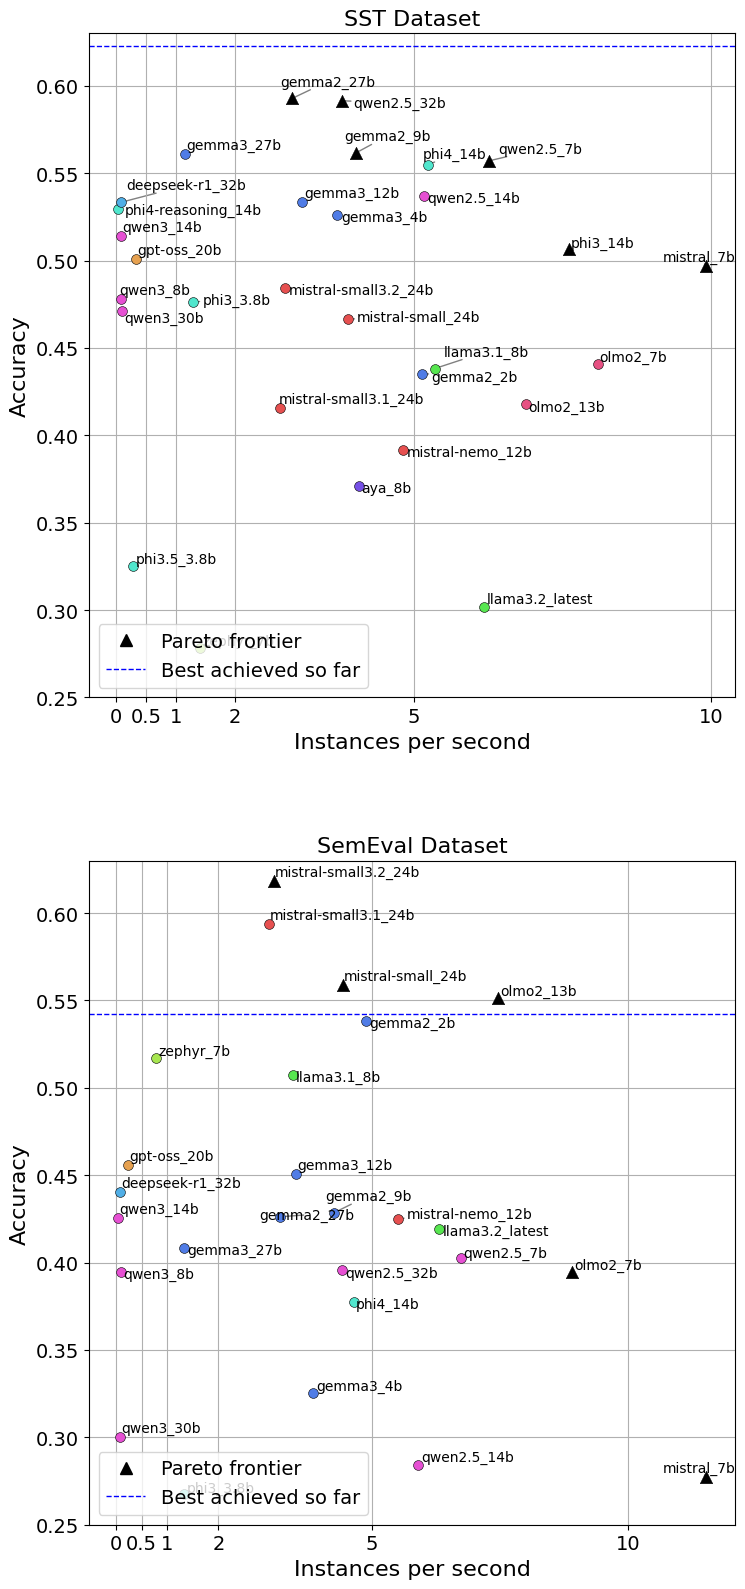

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(8, 16))

axes[0].set_xlabel("Instances per second\n\n\n‎ ", fontsize=16)
axes[0].set_ylabel("Accuracy", fontsize=16)
axes[0].set_title("SST Dataset", fontsize=16)
# axes[0].set_xscale('log')
axes[0].tick_params(axis='y', labelsize=14)

axes[1].set_xlabel("Instances per second", fontsize=16)
axes[1].set_ylabel("Accuracy", fontsize=16)
axes[1].set_title("SemEval Dataset", fontsize=16)
# axes[1].set_xscale('log')
axes[1].tick_params(axis='y', labelsize=14)

axes[0].set_xticks(xticks)
axes[0].set_xticklabels([str(t) for t in xticks], fontsize=14)

axes[1].set_xticks(xticks)
axes[1].set_xticklabels([str(t) for t in xticks], fontsize=14)
for ax in axes:
    ax.set_xticklabels([str(t) for t in xticks])
    

# Ensure every plot starts at y=0
axes[0].set_ylim(bottom=0.25, top = 0.63)
axes[1].set_ylim(bottom=0.25, top = 0.63)
# axes[0].set_ylim(bottom=0.25, top = 1)
# axes[1].set_ylim(bottom=0.25, top = 1)

texts_sst = []
texts_semeval = []
xs_sst = []
ys_sst = []
xs_semeval = []
ys_semeval = []

for file in os.listdir(src):
    if file[-4:] != 'json':
        continue
    #if file[:3] == "phi" or file[:3] == "aya":
        #continue
    path = os.path.join(src, file)
    with open(path, "r") as f:
        performance = json.load(f)
        model_name = file[:-9] if file[-8:] == "sst.json" else file[:-13]
        if file[-8:] == "sst.json":
            x = 1000 / performance["Average end-to-end latency"]
            y = performance["Accuracy"]
            family = get_family(model_name)
            color = get_color_for_family(family)
            axes[0].scatter(x, y, color=color, s=50, edgecolors='k', linewidths=0.4, zorder=3)
            t = axes[0].annotate(model_name, (x, y))
            texts_sst.append(t)
            xs_sst.append(x)
            ys_sst.append(y)
        else:  # semeval
            x = 1000 / performance["Average end-to-end latency"]
            y = performance["Accuracy"]
            family = get_family(model_name)
            color = get_color_for_family(family)
            axes[1].scatter(x, y, color=color, s=50, edgecolors='k', linewidths=0.4, zorder=3)
            t = axes[1].annotate(model_name, (x, y))
            texts_semeval.append(t)
            xs_semeval.append(x)
            ys_semeval.append(y)

plt.tight_layout()
for ax in axes:
    ax.grid(True)
adjust_text_safe(texts_sst, ax=axes[0])
adjust_text_safe(texts_semeval, ax=axes[1])
# Pareto highlighting: higher Accuracy is better
s_idx = pareto_frontier_indices(xs_sst, ys_sst, maximize_x=True, maximize_y=True)
se_idx = pareto_frontier_indices(xs_semeval, ys_semeval, maximize_x=True, maximize_y=True)
highlight_pareto(axes[0], xs_sst, ys_sst, s_idx)
highlight_pareto(axes[1], xs_semeval, ys_semeval, se_idx)
axes[0].axhline(0.6227, color='blue', linestyle='--', linewidth=1)
axes[1].axhline(0.5422, color='blue', linestyle='--', linewidth=1)

# Legend: explain Pareto squares and best-achieved (dashed blue)
pareto_handle = Line2D([0], [0], marker='^', color='black', linestyle='None', markersize=8)
best_handle = Line2D([0], [0], color='blue', linestyle='--', linewidth=1)
axes[0].legend([pareto_handle, best_handle], ['Pareto frontier', 'Best achieved so far'], loc='lower left', fontsize=14)
axes[1].legend([pareto_handle, best_handle], ['Pareto frontier', 'Best achieved so far'], loc='lower left', fontsize=14)

plt.show()

# phi4-mini

In [12]:
data = []

for file in os.listdir(src):
	if file[-4:] != 'json':
		continue
	path = os.path.join(src, file)
	with open(path, "r") as f:
		performance = json.load(f)
		data.append({
			"Model name": file[:-5],
			"Accuracy": performance.get("Accuracy"),
			"Macro-Average Mean Absolute Error": performance["Macro-Average Mean Absolute Error"],
			"Instances per second": 1000 / performance["Average end-to-end latency"]
		})

df = pd.DataFrame(data)
print(df)

                      Model name  Accuracy  Macro-Average Mean Absolute Error  \
0             mistral_7b_semeval  0.277257                           0.649604   
1                 gemma3_12b_sst  0.533484                           0.571371   
2              zephyr_7b_semeval  0.517213                           0.725396   
3                 gemma3_27b_sst  0.561086                           0.555288   
4              gemma3_4b_semeval  0.325174                           0.551063   
..                           ...       ...                                ...   
56                  phi3_14b_sst  0.506346                           0.587586   
57             qwen3_14b_semeval  0.425656                           0.490473   
58             olmo2_13b_semeval  0.551612                           0.602266   
59  mistral-small3.1_24b_semeval  0.593846                           0.738322   
60                qwen2.5_7b_sst  0.557014                           0.523564   

    Instances per second  
